In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU Device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
!pip install efficientnet
import numpy as np
import tensorflow as tf
import keras
import efficientnet.keras as efn
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, UpSampling2D, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
from keras.callbacks import ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Define image size and batch size
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

# Define data generators for train and validation data
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=100)
test_labels = to_categorical(test_labels, num_classes=100)

169001437/169001437 [==============================] - 11s 0us/step


In [ ]:
# Resize train images in batches
num_batches = int(np.ceil(len(train_images) / BATCH_SIZE))
resized_images = []
for i in range(num_batches):
    batch_start = i * BATCH_SIZE
    batch_end = (i + 1) * BATCH_SIZE
    batch_images = train_images[batch_start:batch_end]
    batch_resized = []
    for img in batch_images:
        img_resized = tf.image.resize(img, TARGET_SIZE)
        batch_resized.append(img_resized)
    resized_images.append(np.array(batch_resized))

train_images_resized = np.concatenate(resized_images, axis=0)

In [ ]:
# Resize test images in batches
num_batches = int(np.ceil(len(test_images) / BATCH_SIZE))
resized_images = []
for i in range(num_batches):
    batch_start = i * BATCH_SIZE
    batch_end = (i + 1) * BATCH_SIZE
    batch_images = test_images[batch_start:batch_end]
    batch_resized = []
    for img in batch_images:
        img_resized = tf.image.resize(img, TARGET_SIZE)
        batch_resized.append(img_resized)
    resized_images.append(np.array(batch_resized))

test_images_resized = np.concatenate(resized_images, axis=0)

In [ ]:
# Save the train and test resized images
#np.save('/content/drive/MyDrive/Colab Notebooks/train_images_resized.npy', train_images_resized)
np.save('/content/drive/MyDrive/Colab Notebooks/test_images_resized.npy', test_images_resized)

In [ ]:
# Load the train and test resized images 
#train_images_resized = np.load('/content/drive/MyDrive/Colab Notebooks/train_images_resized.npy')
test_images_resized = np.load('/content/drive/MyDrive/Colab Notebooks/test_images_resized.npy')

In [ ]:
# Define data generators for train and validation data
train_datagen = ImageDataGenerator(rotation_range=0.1,
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=False,
                                   validation_split=0.2)

train_generator = train_datagen.flow(train_images_resized, train_labels, 
                                     batch_size=BATCH_SIZE, 
                                     subset='training')

val_generator = train_datagen.flow(train_images_resized, train_labels, 
                                   batch_size=BATCH_SIZE, 
                                   subset='validation')

In [ ]:
# Initialise the base model
efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*TARGET_SIZE, 3), classes=100)
model = Sequential()
model.add(efnb0)

# Add new layers on top of the pre-trained model
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 100)               128100    
                                                                 
Total params: 4,177,664
Trainable params: 4,135,648
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
# Set up callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.6, 
    min_lr=1e-6)

checkpoint = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto')

In [ ]:
# Train the model
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator),
                    epochs=10, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),
                    callbacks=[early_stop, learning_rate_reduction, checkpoint])

Epoch 1/10
1250/1250 [==============================] - ETA: 0s - loss: 2.4202 - accuracy: 0.4188
Epoch 1: val_accuracy improved from -inf to 0.71740, saving model to /content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5
1250/1250 [==============================] - 524s 378ms/step - loss: 2.4202 - accuracy: 0.4188 - val_loss: 0.9740 - val_accuracy: 0.7174 - lr: 1.0000e-04
Epoch 2/10
1250/1250 [==============================] - ETA: 0s - loss: 1.0699 - accuracy: 0.6935
Epoch 2: val_accuracy improved from 0.71740 to 0.78670, saving model to /content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5
1250/1250 [==============================] - 473s 378ms/step - loss: 1.0699 - accuracy: 0.6935 - val_loss: 0.7011 - val_accuracy: 0.7867 - lr: 1.0000e-04
Epoch 3/10
1250/1250 [==============================] - ETA: 0s - loss: 0.7906 - accuracy: 0.7671
Epoch 3: val_accuracy improved from 0.78670 to 0.80920, saving model to /content/drive/MyDrive/Colab Notebooks/EfficientNet_C

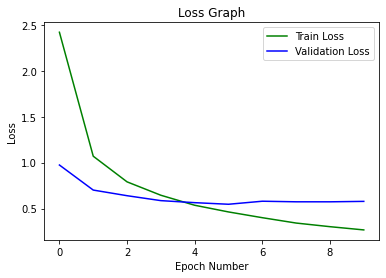

In [ ]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["loss"],color="green",label="Train Loss")
plt.plot(history.epoch,history.history["val_loss"],color="blue",label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()

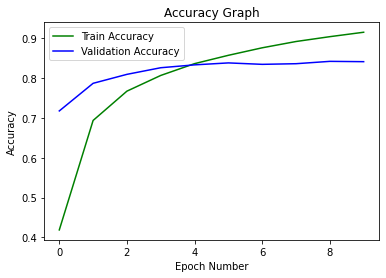

In [ ]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["accuracy"],color="green",label="Train Accuracy")
plt.plot(history.epoch,history.history["val_accuracy"],color="blue",label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5")

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5")

In [ ]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_images_resized, test_labels, verbose=0)
print("Test accuracy without attack: {:.4f}".format(test_acc))

Test accuracy without attack: 0.8485


In [ ]:
# Make predictions on the test data
y_pred = model.predict(test_images_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(test_labels, axis=1)

# Find the indices of the correctly predicted samples
correct_indices = np.nonzero(y_pred_classes == y_true_classes)[0]

313/313 [==============================] - 203s 643ms/step


In [ ]:
# Select a random sample of 2500 correctly predicted samples
num_samples = 2500
selected_indices = np.random.choice(correct_indices, num_samples, replace=False)
selected_images = test_images_resized[selected_indices]
selected_labels = test_labels[selected_indices]

print('Selected images shape:', selected_images.shape)
print('Selected labels shape:', selected_labels.shape)

# Save the selected images and labels
np.save('/content/drive/MyDrive/Colab Notebooks/selected_images.npy', selected_images)
np.save('/content/drive/MyDrive/Colab Notebooks/selected_labels.npy', selected_labels)

Selected images shape: (2500, 224, 224, 3)
Selected labels shape: (2500, 100)


In [ ]:
import tensorflow as tf
import numpy as np

selected_images = np.load('/content/drive/MyDrive/Colab Notebooks/selected_images.npy')
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/selected_labels.npy')
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5")

**Generating Adversarial Examples using Fast Gradient Sign Method (FGSM)**

In [ ]:
# Define the FGSM attack function
def fgsm_attack(model, images, labels, eps, batch_size=50):
  
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Compute the gradient of the loss with respect to the input
        x_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        # Record the gradient tape
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            y_pred = model(x_tensor)
            loss_value = tf.keras.losses.categorical_crossentropy(batch_labels, y_pred)
        gradient = tape.gradient(loss_value, x_tensor)

        # Generate the adversarial examples with FGSM
        adv_images_batch = batch_images + eps * tf.sign(gradient)
        adv_images_batch = tf.clip_by_value(adv_images_batch, 0, 1)
    
        # Compute the adversarial examples for the batch
        adv_images.extend(adv_images_batch.numpy())
    
    return adv_images

In [ ]:
# Perform the FGSM attack on the sample of test images
eps = 0.1
adv_images = fgsm_attack(model, selected_images, selected_labels, eps)

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/adv_images_fgsm.npy', adv_images)
# Evaluate the accuracy of the classification on the original and perturbed images
acc_orig = model.evaluate(selected_images, selected_labels, verbose=0)[1]
acc_adv = model.evaluate(np.array(adv_images), selected_labels, verbose=0)[1]

print('Accuracy of benign images: {:4f}'.format(acc_orig))
print('Accuracy of adversarial examples: {:4f}'.format(acc_adv))

Accuracy of benign images: 1.000000
Accuracy of adversarial examples: 0.011200


**Defence against FGSM Attack**

In [ ]:
# Load the fgsm adversarial images from the numpy file 
import numpy as np
import tensorflow as tf

num_samples = 2500
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5")
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/adv_images_fgsm.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0097 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0096 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0064 seconds
79/79 [==============================] - 52s 631ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.0112
79/79 [==============================] - 48s 611ms/step
Accuracy on adversarial examples with webp compression: 0.0112
79/79 [==============================] - 58s 722ms/step
Accuracy on adversarial examples with jpeg compression: 0.0112
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0116 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0114 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0074 seconds
79/79 [====

**Generating Adversarial Examples using Iterative Fast Gradient Sign Method (IFGSM)** 

In [ ]:
def ifgsm_batch(model, images, labels, eps=0.01, alpha=0.005, num_iter=10, batch_size=50):
    """
    Implements the iterative fast gradient sign method (IFGSM) attack on a given model.
    
    Args:
    - model: the target model to attack
    - images: a batch of input images to be attacked
    - labels: the true labels for the input images
    - eps: the maximum perturbation that can be added to each pixel (default: 0.01)
    - alpha: the step size for each iteration of the attack (default: 0.005)
    - num_iter: the number of iterations to run the attack (default: 10)
    - batch_size: the number of images to attack at once (default: 50)
    
    Returns:
    - adv_images: the adversarial images generated by the attack
    """
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Create a tensor from the batch images
        x = tf.convert_to_tensor(batch_images, dtype=tf.float32)

        # Iterate the FGSM attack
        for j in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x)
                pred = model(x)
                loss = tf.keras.losses.categorical_crossentropy(batch_labels, pred)
            grad = tape.gradient(loss, x)
            signed_grad = tf.sign(grad)
            x += alpha * signed_grad
            x = tf.clip_by_value(x, 0, 1)

        # Compute the adversarial examples for the batch
        adv_images_batch = x.numpy()
        adv_images.extend(adv_images_batch)

    return np.array(adv_images)


In [ ]:
# Generate adversarial examples using IFGSM
adv_images = ifgsm_batch(model, selected_images, selected_labels, eps=0.01, alpha=0.005, num_iter=10, batch_size=50)
num_samples = 2500

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/adv_images_ifgsm.npy', adv_images)


In [ ]:
# Evaluate the accuracy of the classification on the original and perturbed images
acc_orig = model.evaluate(selected_images, selected_labels, verbose=0)[1]
acc_adv = model.evaluate(np.array(adv_images), selected_labels, verbose=0)[1]

print('Accuracy of benign images: {:4f}'.format(acc_orig))
print('Accuracy of adversarial examples: {:4f}'.format(acc_adv))


Accuracy of benign images: 1.000000
Accuracy of adversarial examples: 0.000000


**Defence against Iterative FGSM Attack**

In [ ]:
# Load the ifgsm adversarial images from the numpy file 
import numpy as np
import tensorflow as tf

num_samples = 2500
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5")
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/adv_images_ifgsm.npy')
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/selected_labels.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/10000))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/10000))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/10000))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0027 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0032 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0029 seconds
79/79 [==============================] - 78s 966ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.0112
79/79 [==============================] - 51s 644ms/step
Accuracy on adversarial examples with webp compression: 0.0112
79/79 [==============================] - 50s 634ms/step
Accuracy on adversarial examples with jpeg compression: 0.0112
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0047 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0050 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0047 seconds
79/79 [====

**Generating Adversarial Examples using Projected Gradient Descent (PGD)** 

In [ ]:
def pgd_batch(model, images, labels, eps=0.01, alpha=0.005, num_iter=10, 
              batch_size=50):
    """
    Implements the projected gradient descent (PGD) attack on a given model with 
    random initialization of the starting point within a boundary.
    
    Args:
    - model: the target model to attack
    - images: a batch of input images to be attacked
    - labels: the true labels for the input images
    - eps: the maximum perturbation that can be added to each pixel 
    (default: 0.01)
    - alpha: the step size for each iteration of the attack (default: 0.005)
    - num_iter: the number of iterations to run the attack (default: 10)
    - batch_size: the number of images to attack at once (default: 50)
    
    Returns:
    - adv_images: the adversarial images generated by the attack
    """
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Randomly perturb the batch images within the range [-eps, eps]
        perturbations = tf.random.uniform(shape=batch_images.shape, minval=-eps, 
                                          maxval=eps)
        batch_images = tf.clip_by_value(batch_images + perturbations, 0, 1)

        # Create a tensor from the batch images
        x = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        
        # Initialize the perturbation to zero
        delta = tf.zeros_like(x)

        # Iterate the PGD attack
        for j in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x)
                loss = tf.keras.losses.categorical_crossentropy(batch_labels, 
                                                                model(x + delta))
            grad = tape.gradient(loss, x)
            signed_grad = tf.sign(grad)
            delta += alpha * signed_grad
            delta = tf.clip_by_value(delta, -eps, eps)
            x = tf.clip_by_value(x + delta, 0, 1)

        # Compute the adversarial examples for the batch
        adv_images_batch = x.numpy()
        adv_images.extend(adv_images_batch)

    return np.array(adv_images)


In [ ]:
# Generate adversarial examples using PGD
adv_images = pgd_batch(model, selected_images, selected_labels)
num_samples = 2500

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/adv_images_pgd.npy', adv_images)

# Evaluate the accuracy of the classification on the original and perturbed images
acc_orig = model.evaluate(selected_images, selected_labels, verbose=0)[1]
acc_adv = model.evaluate(np.array(adv_images), selected_labels, verbose=0)[1]

print('Accuracy of benign images: {:4f}'.format(acc_orig))
print('Accuracy of adversarial examples: {:4f}'.format(acc_adv))

Accuracy of benign images: 1.000000
Accuracy of adversarial examples: 0.000000


**Defence against PGD Attack**

In [ ]:
# Load the pgd adversarial images from the numpy file 
import numpy as np
import tensorflow as tf

num_samples = 2500
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/EfficientNet_CIFAR100.hdf5")
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/adv_images_pgd.npy')
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/selected_labels.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images1/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images1/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/Images1/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images1/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images1/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/Images1/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0123 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0137 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0128 seconds
79/79 [==============================] - 52s 634ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.0112
79/79 [==============================] - 50s 637ms/step
Accuracy on adversarial examples with webp compression: 0.0112
79/79 [==============================] - 50s 627ms/step
Accuracy on adversarial examples with jpeg compression: 0.0112
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0185 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0222 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0184 seconds
79/79 [====